In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from keras.utils import to_categorical
from keras.models import Model
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, Input, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping

from keras.layers import concatenate

Using TensorFlow backend.


In [136]:
from sklearn.metrics import f1_score, confusion_matrix, recall_score, precision_score, make_scorer

from sklearn.metrics import hamming_loss
from sklearn.multiclass import OneVsRestClassifier

from sklearn.model_selection import KFold, cross_validate

from imblearn.metrics import geometric_mean_score
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline



In [113]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

## Parameters

In [4]:
PREFILTER = True
PREFILTER_THRESHOLD = 0.2 # Data excluded if Brand variance greather than 0.2M or less than -0.2M

WINDOW_SIZE = 13 # Timeseries window size in months

MULTILABEL = True

UNDERSAMPLE = True
UNDERSAMPLE_RATIO = 0.6 #  Amount of data with no comment =  Amount of data with comment / UNDERSAMPLE_RATIO
EXTRA_TEST_DATA = 100 # Amount of data thrown out when undersampling to include in the test set

OVERSAMPLE = True

# AUGMENT_DATA = True

# DATA = ["Variance"] # "Variance", "All", 
# MODEL = "LSTM"    # 


## Loading Data

commentaries_to_pickle.py to save commentary excel spreedsheet to pickle

In [190]:
from helper_save_load import load_from_pickle

df_c = load_from_pickle("data/Labeled_comments3.pkl")

In [192]:
# Inserting NoCommentary column
df_c.insert(16, "NoComm", df_c["Commentaries"].isnull())

# Inserting Other column where there is a commentary but it does not belong to a class
df_c.insert(16, "Other", (df_c[['Promo', 'Phasing', 'SP&D', 'POS']].sum(axis=1) == 0) & ~df_c['NoComm'])

df_c["Month"] = pd.to_datetime(df_c["Month"]).dt.strftime("%b_%Y")

In [193]:
label_cols = ['Promo', 'Phasing', 'SP&D', 'POS', 'Other', 'NoComm']

territory_label_cols = df_c.columns[18:31].to_list()

In [194]:
# Load variance data
df_a, df_f, df_v = load_from_pickle("data/dataframes_Dollars.pickle")
del df_a, df_f

## Pre-Filtering Data
Including data if variance on the brand is greater than the 0.2M threshold

In [196]:
test = df_c[(~df_c["Num"].duplicated())]
len(test[test["NoComm"] == 1]) / len(test) # Fraction of number of brand-month pairs with no commentaries

0.7415946205571565

In [197]:
if PREFILTER:
    df_c = df_c[(df_c["Variance"] >= PREFILTER_THRESHOLD) | (df_c["Variance"] <= -PREFILTER_THRESHOLD)]

In [198]:
test = df_c[(~df_c["Num"].duplicated())]
len(test[test["NoComm"] == 1]) / len(test) #Fraction of number of brand-month pairs with no commentaries after filtering

0.12237762237762238

## Reshaping Data

In [199]:
# variances grouped by territory and brand
TR_BR_grouped = df_v.groupby(["Territory", "Brand"]).sum()

Summing variances for all associated subterritories for each labeled territory and placing them in a dictionary

In [201]:
# Summed variances aggregated by the territory_dict
variance_dict = {}
for territory, subterritories in territory_dict.items():
    summed_variance = pd.DataFrame()
    for subterritory in subterritories:
        summed_variance = summed_variance.add(TR_BR_grouped.loc[subterritory], fill_value=0)
        
    variance_dict[territory] = summed_variance

In [ ]:
# Brand count sold by each territory
for t, v in variance_dict.items():
    print(t, v.shape[0])

Variance time series (all months) for labeled territories. Zeros if no data for brand-territory.

In [204]:
# Brand x territory x months
# Row of zeros if empty
brands = df_v["Brand"].unique()
months = df_v.columns[8:]

all_brands_variance = []

for brand in brands:
    temp = []
    for territory in territory_label_cols:
        if brand in variance_dict[territory].index:
            temp.append(variance_dict[territory].loc[brand].values)
        else:
            temp.append(np.zeros(len(months)))
    all_brands_variance.append(temp)
    
all_brands_variance = np.array(all_brands_variance)
all_brands_variance.shape

(136, 13, 34)

For each unique brand-month pair (known to be unique by the "Num" column) we take a 12 month window of data for each labeled territory. Thus the output should have #unique brand-month pairs * 13 territories rows.

The labels are generated as well. The default label for when a territory is not involved is [0, 0, 0, 0, 0]

In [278]:
# Generates full list of 12 month timeseries windows and corresponding class labels
# for every *unique* brand-month pair in commentary spreadsheet
# Uniqueness is determined by the Num column

labels = []
BR_TR_timeseries_windows = []
previous_commentary_num = -1
brand_month_labels = None

for idx, row in df_c.iterrows():
    brand_idx = np.where(brands==row["Brand_1"])[0][0] # Index in the brands list for this row
    month_idx = np.where(months==row["Month"])[0][0]   # Index in the months list for this row
    t_idx = np.flatnonzero(row.fillna(0)[territory_label_cols]) # Index of the territory label for this row
    
    # Due to splitting of commentaries we have repeated brand-month pairs in data
    # Keeping track of which commentary so we don't repeat its timeseries
    current_commentary_num = row["Num"] 
    
    if current_commentary_num != previous_commentary_num:
        # First instance of brand-month pair
        labels.append(brand_month_labels)
        
        brand_month_labels = np.zeros((len(territory_label_cols), len(label_cols)), dtype=int)
        brand_month_labels[:, 5] = 1 # Default NoComm
        
        if t_idx.size > 0:
            brand_month_labels[t_idx[0]] = row[label_cols].fillna(0).values
        
        for i in range(len(territory_label_cols)):

            # Appending WINDOW_SIZE length month windows per brand per territory as input
            if month_idx - WINDOW_SIZE < 0:
                padding = np.zeros(WINDOW_SIZE - month_idx-1) # pad with zeros if less than WINDOW_SIZE
                window = np.concatenate((padding, all_brands_variance[brand_idx, i, :month_idx+1]))
            else:
                window = all_brands_variance[brand_idx, i, (month_idx-WINDOW_SIZE+1):month_idx+1]
            BR_TR_timeseries_windows.append(window)
    else:
        # Repeated instances of brand-month pair (Num is the same)
        if t_idx.size > 0:
            brand_month_labels[t_idx[0]] = row[label_cols].fillna(0).values

    previous_commentary_num = current_commentary_num
    
labels.append(brand_month_labels) # Append the final labels
BR_TR_timeseries_windows = np.array(BR_TR_timeseries_windows)
BR_TR_labels = np.vstack(labels[1:])
BR_TR_timeseries_windows /= 1e6 

print("X data shape:", BR_TR_timeseries_windows.shape) # 286 brand-month pairs * 13 territories, 12 months
print("y data shape:", BR_TR_labels.shape)             # 286 brand-month pairs * 13 territories, 5 labels

X data shape: (3718, 13)
y data shape: (3718, 6)


In [206]:
df_c.Num.nunique() # Number of unique brand-month pairs i.e. number of unsplit commentaries 

286

In [279]:
sum(BR_TR_labels) # Class memberships (Promo, Phasing, SP&D, POS, Other, NoComm)

array([ 139,  112,   13,  108,   28, 3383])

## Multi-label Characterizing Measures

Need to decide on which columns are actually considered as labels

In [303]:
# Label Cardinality
# The average number of labels of the examples in our data 

print('All label cols:',np.round(np.mean(BR_TR_labels.sum(axis=1)), 3))
print('No NoComm:', np.round(np.mean(BR_TR_labels[:, :-1].sum(axis=1)), 3))
print('No NoComm and No other:', np.round(np.mean(BR_TR_labels[:, :-2].sum(axis=1)), 3))

All label cols: 1.017
No NoComm: 0.108
No NoComm and No other: 0.1


In [304]:
# Label Cardinality Density
# Label Cardinality over number of classes
print('All label cols:',np.round(np.mean(BR_TR_labels.sum(axis=1)/len(label_cols)), 3))
print('No NoComm:', np.round(np.mean(BR_TR_labels[:, :-1].sum(axis=1)/len(label_cols)), 3))
print('No NoComm and No other:', np.round(np.mean(BR_TR_labels[:, :-2].sum(axis=1)/len(label_cols)), 3)) 

All label cols: 0.17
No NoComm: 0.018
No NoComm and No other: 0.017


In [535]:
# Imbalance Ratio. Zhang et al.
def imbalance_ratio(y):
    positives = sum(y)
    negatives = len(y) - sum(y)

    imbalance_ratios = [max(pos, neg) / min(pos, neg) for (pos, neg) in zip(positives, negatives)]
    return np.mean(imbalance_ratios)

print('All label cols:',np.round(imbalance_ratio(BR_TR_labels), 3))
print('No NoComm:', np.round(imbalance_ratio(BR_TR_labels[:, :-1]), 3))
print('No NoComm and No other:', np.round(imbalance_ratio(BR_TR_labels[:, :-2]), 3)) 

All label cols: 86.376
No NoComm: 101.631
No NoComm and No other: 94.093


In [544]:
# Charte et al.
def mean_imbalance_ratio(y):
    majority = max(sum(y))
    label_sums = sum(y)
    
    imbalance_ratios_per_label = majority / label_sums
    return np.mean(imbalance_ratios_per_label)

print('All label cols:',np.round(mean_imbalance_ratio(BR_TR_labels), 3))
print('No NoComm:', np.round(mean_imbalance_ratio(BR_TR_labels[:, :-1]), 3))
print('No NoComm and No other:', np.round(mean_imbalance_ratio(BR_TR_labels[:, :-2]), 3))

All label cols: 77.987
No NoComm: 3.837
No NoComm and No other: 3.555


In [547]:
# coefficient of variation of imbalance ratio per label. Charte et al.
def cvir(y):
    majority = max(sum(y))
    label_sums = sum(y)
    
    imbalance_ratios_per_label = majority / label_sums
    mean_imbalance_ratio = np.mean(imbalance_ratios_per_label)
    
    return np.sqrt(sum((imbalance_ratios_per_label - mean_imbalance_ratio)**2)/(len(y)-1))

print('All label cols:',np.round(cvir(BR_TR_labels), 3))
print('No NoComm:', np.round(cvir(BR_TR_labels[:, :-1]), 3))
print('No NoComm and No other:', np.round(cvir(BR_TR_labels[:, :-2]), 3))

All label cols: 3.605
No NoComm: 0.137
No NoComm and No other: 0.135


## Undersampling

Throwing out some of the No Comment data including timeseries with 0 for all values.

In [280]:
if UNDERSAMPLE:
    
    print("Length of data:",len(BR_TR_timeseries_windows))
    print("No Comment:", sum(BR_TR_labels[:, 5] == 1))
    print("With Comment:", sum(BR_TR_labels[:, 5] == 0))
    
    nonzero_data = np.where(BR_TR_timeseries_windows.sum(axis=1) != 0)
    X = BR_TR_timeseries_windows[nonzero_data]
    y = BR_TR_labels[nonzero_data]
    
    no_comment_idx = np.where(y[:, 5] == 1)[0]
    with_comment_idx = np.where(y[:, 5] == 0)[0]

    no_comment_count = sum(y[:, 5] == 1)   
    with_comment_count = sum(y[:, 5] == 0)
    
    np.random.shuffle(no_comment_idx)
    undersample_no_comment_idx = no_comment_idx[:int(with_comment_count/UNDERSAMPLE_RATIO)]
    excluded_data_idx = no_comment_idx[int(with_comment_count/UNDERSAMPLE_RATIO):]
    
    
    undersample_idx = np.concatenate((undersample_no_comment_idx, with_comment_idx))
    undersample_idx.sort(kind='mergesort') # Preserving order of data
    
    excluded_data = X[excluded_data_idx]
    excluded_labels = y[excluded_data_idx]
    
    X = X[undersample_idx]
    y = y[undersample_idx]

Length of data: 3718
No Comment: 3383
With Comment: 335


In [281]:
print("Length of data:", len(X))
print("No Comment:", sum(y[:, 5] == 1))
print("With Comment:", sum(y[:, 5] == 0))

Length of data: 856
No Comment: 535
With Comment: 321


In [282]:
# Time series with zero data Before and after
sum(BR_TR_timeseries_windows.sum(axis=1)==0), sum(X.sum(axis=1) == 0) 

(1075, 0)

In [536]:
# Imbalance ratios after throwing out some no comment data
print('All label cols:',np.round(imbalance_ratio(y), 3))
print('No NoComm:', np.round(imbalance_ratio(y[:, :-1]), 3))
print('No NoComm and No other:', np.round(imbalance_ratio(y[:, :-2]), 3)) 

All label cols: 19.683
No NoComm: 23.286
No NoComm and No other: 21.127


## Making a test set

In [283]:
from sklearn.model_selection import train_test_split

# Not necessarily a good way to split as the classes are so imbalanced
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Add data to test set that was thrown out when undersampling
if UNDERSAMPLE:
    X_test = np.concatenate((X_test, excluded_data[:EXTRA_TEST_DATA]))
    y_test = np.concatenate((y_test, excluded_labels[:EXTRA_TEST_DATA]))

## Oversampling small classes

In [284]:
# This does not work with multilabel



# Naive oversampling
if OVERSAMPLE:
    print("Class memberships before:", sum(y_train))
    ros = RandomOverSampler()
    X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
    print("Class memberships after:", sum(y_resampled))

Class memberships before: [102  89  11  87  21 422]
Class memberships after: [422 422 422 422 422 422]


## Augmenting data with noise

In [54]:
# Adding noise to variance data to generate more samples to learn from

## Plotting model

In [57]:
import matplotlib.pyplot as plt

%matplotlib inline

def plot_model(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title('model loss')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.title('model accuracy')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

## Binary Relevance Pipeline

Basic transformation method. Considers a binary classifier for each class.

In [214]:
def binary_relevance_classification(estimator, sampling='ros'):
    if sampling == 'ros':
        oversampler = RandomOverSampler()
    elif sampling == 'smote':
        oversampler = SMOTE()
    else:
        return OneVsRestClassifier(estimator)
    
    # Pipeline is wrong. Try like labelpowerset .
    
    binary_pipe = Pipeline([('oversampler', oversampler), ('clf', estimator)])
    return OneVsRestClassifier(binary_pipe)

In [320]:
# With skmultilearn instead. These are equivalent
from skmultilearn.problem_transform import BinaryRelevance

def binary_relevance_classification(estimator, sampling='ros'):
    if sampling == 'ros':
        oversampler = RandomOverSampler()
    elif sampling == 'smote':
        oversampler = SMOTE()
    else:
        return BinaryRelevance(estimator)
    
    # Is oversampling happening before the splitting or after?
        
    binary_pipe = Pipeline([('oversampler', oversampler), ('clf', estimator)])
    return BinaryRelevance(binary_pipe)

## Label power set pipeline

In [508]:
from skmultilearn.problem_transform import LabelPowerset
from imblearn import FunctionSampler
from sklearn.utils import shuffle

# Error with oversampling somewhere in this pipeline

# Need to keep lp to invert transform after prediction

def oversample_powerset(X, y, oversampler):
    #https://github.com/scikit-learn-contrib/imbalanced-learn/issues/340
    lp = LabelPowerset()
    yt = lp.transform(y)
    
    Xr, yr = oversampler.fit_resample(X, yt)
    
    return Xr, yr, lp
    
def label_powerset_classification(estimator, sampling='ros'):
    
    if sampling == 'ros':
        oversampler = FunctionSampler(func=oversample_powerset, kw_args={'oversampler':RandomOverSampler()})
    elif sampling == 'smote':
        oversampler = FunctionSampler(func=oversample_powerset, kw_args={'oversampler':SMOTE()})
    else:
        oversampler = FunctionSampler(func=oversample_powerset, kw_args={'oversampler':sampling})
        
    powerset_pipe = Pipeline([('oversampler', oversampler), ('clf', estimator)])
    
    return LabelPowerset(powerset_pipe)

In [ ]:
Xr, yr, lp = oversample_powerset(X_train, y_train, SMOTE())

In [522]:
sum(y_test)

array([ 28,  17,   2,  20,   5, 213])

In [520]:
sum(lp.inverse_transform(rf.predict(X_test)).toarray())

array([  5,   4,   1,   9,   0, 255])

In [523]:
rf = RandomForestClassifier(100).fit(X_train, y_train)
evaluate_prediction(y_test, rf.predict(X_test))

/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


{'hamming_loss': 0.09681372549019608,
 'precision_macro': 0.1446360153256705,
 'precision_micro': 0.8628571428571429,
 'recall_macro': 0.11815336463223787,
 'recall_micro': 0.5298245614035088,
 'f1_score_macro': 0.13006029285099055,
 'f1_score_micro': 0.6565217391304348}

In [515]:
rf = RandomForestClassifier(100).fit(Xr, yr)
evaluate_prediction(y_test, lp.inverse_transform(rf.predict(X_test)))

/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


{'hamming_loss': 0.08884803921568628,
 'precision_macro': 0.18888888888888888,
 'precision_micro': 0.7554744525547445,
 'recall_macro': 0.1846244131455399,
 'recall_micro': 0.7263157894736842,
 'f1_score_macro': 0.17978190391983495,
 'f1_score_micro': 0.740608228980322}

In [481]:
lp = label_powerset_classification(RandomForestClassifier(200, max_depth=6))
lp.fit(X_train, y_train)

LabelPowerset(classifier=Pipeline(memory=None,
     steps=[('oversampler', FunctionSampler(accept_sparse=True,
        func=<function oversample_powerset at 0x7f800026c048>,
        kw_args={'oversampler': RandomOverSampler(random_state=None, ratio=None, return_indices=False,
         sampling_strategy='auto')})), ('clf', RandomForestClassifier(boots...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       require_dense=[True, True])

In [482]:
sum(lp.predict(X_test).toarray())

array([  0,  93,   0,   0,   0, 179])

In [455]:
evaluate_prediction(y_test,lp.predict(X_test))

{'hamming_loss': 0.14767156862745098,
 'precision_macro': 0.1607511628355818,
 'precision_micro': 0.5808823529411765,
 'recall_macro': 0.21384516247813679,
 'recall_micro': 0.5543859649122806,
 'f1_score_macro': 0.1567208097928437,
 'f1_score_micro': 0.5673249551166966}

In [347]:
br = binary_relevance_classification(RandomForestClassifier(100))
br.fit(X_train, y_train)

BinaryRelevance(classifier=Pipeline(memory=None,
     steps=[('oversampler', RandomOverSampler(random_state=None, ratio=None, return_indices=False,
         sampling_strategy='auto')), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
        require_dense=[True, True])

## Defining Multilabel Metrics

In [309]:
def evaluate_prediction(y_true, y_pred, averaging='macro'):
    results = {}
    
    results['hamming_loss'] = hamming_loss(y_true, y_pred)
    results['precision_macro'] = precision_score(y_true, y_pred, average='macro')
    results['precision_micro'] = precision_score(y_true, y_pred, average='micro')
    results['recall_macro'] = recall_score(y_true, y_pred, average='macro')
    results['recall_micro'] = recall_score(y_true, y_pred, average='micro')
    results['f1_score_macro'] = f1_score(y_true, y_pred, average='macro')
    results['f1_score_micro'] = f1_score(y_true, y_pred, average='micro')
    
#     print("Hamming Loss:", hamming_loss(y_true, y_pred))
#     print("Precision:", precision_score(y_true, y_pred, average=averaging))
#     print("Recall:", recall_score(y_true, y_pred, average=averaging))
#     print("F1-score:", f1_score(y_true, y_pred, average=averaging))
    
    return results

In [323]:
def evaluate_model(estimator, X, y, transform='binary_relevance'):
    pre = []
    rec = []
    fs = []
    hl = []

    for _ in range(10):

        cv = KFold(n_splits=5, shuffle=True)

        scoring = {'precision': make_scorer(precision_score, average='macro'),
                   'recall': make_scorer(recall_score, average='macro'),
                   'f1': make_scorer(f1_score, average='macro'),
                  'hamming_loss': make_scorer(hamming_loss)}

        if transform == 'binary_relevance':
            clf = binary_relevance_classification(estimator)
        elif transform == 'label_powerset':
            clf = LabelPowerset(estimator)
        else:
            raise ValueError('transform options: binary_relevance, label_powerset')
        scores = cross_validate(clf, X, y, cv=cv, scoring=scoring, n_jobs=-1)

        pre.append(np.mean(scores['test_precision']))
        rec.append(np.mean(scores['test_recall'])) 
        fs.append(np.mean(scores['test_f1']))    
        hl.append(np.mean(scores['test_hamming_loss']))
    
    print('Precision: %.4f' % np.mean(pre), end='  ')
    print('Recall: %.4f' % np.mean(rec), end='  ')
    print('F1-score: %.4f' % np.mean(fs), end='  ')
    print('Hamming loss: %.4f' % np.mean(hl))
    return np.mean(hl)

In [263]:
y_5 = y[:, :-1] # Not considering NoComm as a class
y_4 = y[:, :-2] # Not considering NoComm or Other as classes

## Random Forest

In [305]:
# Try different n_estimators as well (Grid search)
h_loss = []

for depth in [6, 8, 10, 12, 14, 16, None]:
    print('depth =', depth)
    h_loss.append(evaluate_model(RandomForestClassifier(100, max_depth=depth), X, y))

depth = 6
Precision: 0.2359  Recall: 0.2082  F1-score: 0.2180  Hamming loss: 0.1606
depth = 8
Precision: 0.2342  Recall: 0.1565  F1-score: 0.1755  Hamming loss: 0.1385
depth = 10
Precision: 0.2143  Recall: 0.1385  F1-score: 0.1513  Hamming loss: 0.1305
depth = 12
Precision: 0.1953  Recall: 0.1306  F1-score: 0.1405  Hamming loss: 0.1299
depth = 14
Precision: 0.2204  Recall: 0.1314  F1-score: 0.1429  Hamming loss: 0.1278
depth = 16
Precision: 0.1992  Recall: 0.1274  F1-score: 0.1376  Hamming loss: 0.1281
depth = None
Precision: 0.2090  Recall: 0.1300  F1-score: 0.1410  Hamming loss: 0.1273


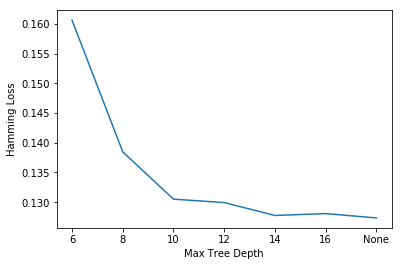

In [306]:
# Fscore is decreasing however
plt.plot(h_loss)
plt.ylabel('Hamming Loss')
plt.xlabel('Max Tree Depth')
plt.xticks(range(7), ['6', '8', '10', '12', '14', '16', 'None'])
plt.show()

## kNN

In [275]:
h_loss = []
for k in range(1, 6):
    print('\nk =', k)
    h_loss.append(evaluate_model(KNeighborsClassifier(k), X, y_4))


k = 1
Precision: 0.1256  Recall: 0.0997  F1-score: 0.1084  Hamming loss: 0.1623

k = 2
Precision: 0.1272  Recall: 0.1070  F1-score: 0.1127  Hamming loss: 0.1620

k = 3
Precision: 0.1387  Recall: 0.2085  F1-score: 0.1642  Hamming loss: 0.2050

k = 4
Precision: 0.1356  Recall: 0.2004  F1-score: 0.1591  Hamming loss: 0.2046

k = 5
Precision: 0.1385  Recall: 0.2780  F1-score: 0.1812  Hamming loss: 0.2416


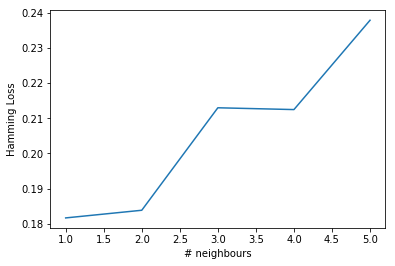

In [218]:
plt.plot(range(1,6), h_loss)
plt.ylabel('Hamming Loss')
plt.xlabel('# neighbours')
plt.show()

## Gradient Boost

In [324]:
evaluate_model(GradientBoostingClassifier(), X, y, 'label_powerset')

Precision: 0.2374  Recall: 0.2047  F1-score: 0.2011  Hamming loss: 0.1467


0.14674883267600528

## SVM

In [319]:
evaluate_model(SVC(C=1000), X, y)

Precision: 0.2260  Recall: 0.2903  F1-score: 0.2473  Hamming loss: 0.1988


0.19875526995784035

## MLP

In [189]:
from sklearn.neural_network import MLPClassifier
evaluate_model(MLPClassifier(), X, y)

Precision: 0.2137  Recall: 0.2720  F1-score: 0.2345  Hamming loss: 0.1974


0.1973675600417682

In [ ]:
# Can consider Time series classification algorithms as well
# https://tslearn.readthedocs.io/en/latest/gettingstarted.html

## Naive Baselines

In [312]:
no_comm = np.zeros(y.shape)
no_comm[:, -1] = 1
no_comm

array([[0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]])

In [313]:
# Guess No Comment every time
evaluate_prediction(y, no_comm)

/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


{'hamming_loss': 0.13687694704049844,
 'precision_macro': 0.10416666666666667,
 'precision_micro': 0.625,
 'recall_macro': 0.16666666666666666,
 'recall_micro': 0.5834242093784079,
 'f1_score_macro': 0.12820512820512822,
 'f1_score_micro': 0.6034968979131415}

In [314]:
# Random Guessing each label
random_y = np.random.randint(2, size=y.shape)
evaluate_prediction(y, random_y)

{'hamming_loss': 0.5,
 'precision_macro': 0.17411804804706976,
 'precision_micro': 0.17766497461928935,
 'recall_macro': 0.47808485818536955,
 'recall_micro': 0.4961832061068702,
 'f1_score_macro': 0.20647730777421602,
 'f1_score_micro': 0.261644623346751}

In [239]:
random_y

array([[0, 0, 0, 1, 0, 1],
       [1, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 0, 1],
       ...,
       [0, 1, 1, 0, 0, 1],
       [1, 0, 1, 1, 1, 0],
       [0, 1, 1, 0, 1, 1]])

In [310]:
# Random guessing a single class
random_single_class = to_categorical(np.random.randint(6, size=len(y)), dtype=int)
evaluate_prediction(y, random_single_class)

{'hamming_loss': 0.28407320872274144,
 'precision_macro': 0.17295497330552104,
 'precision_micro': 0.18341121495327103,
 'recall_macro': 0.126826544407218,
 'recall_micro': 0.17121046892039257,
 'f1_score_macro': 0.12468046848935743,
 'f1_score_micro': 0.17710095882684715}

In [258]:
random_single_class

array([[0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 0]])

In [ ]:
import skmultilearn.

## Random Forest

In [58]:
from sklearn.metrics import roc_curve, auc

In [212]:
ros = RandomOverSampler()
X_binary, y_binary = ros.fit_resample(X_train, 1 -  y_train[:, 5])

In [298]:
pre = []
rec = []
fs = []
gms = []
wa = []

for _ in range(100):
    rf = RandomForestClassifier(200)
    rf.fit(X_binary, y_binary) # 1 if comment, 0 if no comment
    
    predictions = rf.predict(X_test)
    pre.append(precision_score(1 - y_test[:, 5], predictions))
    rec.append(recall_score(1 - y_test[:, 5], predictions))
    fs.append(f1_score(1 - y_test[:, 5], predictions))
    gms.append(geometric_mean_score(1 - y_test[:, 5], predictions, average='binary'))
    wa.append(balanced_accuracy_score(1 - y_test[:, 5], predictions))

In [299]:
print(np.mean(pre), np.mean(rec), np.mean(fs), np.mean(gms), np.mean(wa))

0.4077695532059648 0.5868571428571429 0.4810383685973719 0.6414360415628743 0.6443035714285714


In [243]:
predictions = rf.predict(X_test)

In [244]:
sum(predictions)

100

In [245]:
sum(1 - y_test[:,5])

70

In [246]:
conf_matrix = confusion_matrix(1 - y_test[:,5], predictions)
conf_matrix

array([[142,  58],
       [ 28,  42]])

In [247]:
tn, fp, fn, tp = conf_matrix.ravel()

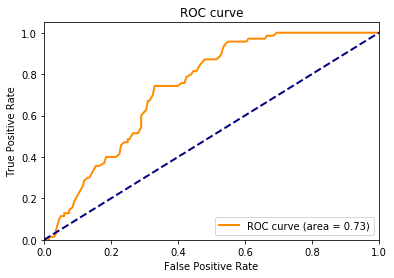

In [248]:
score = rf.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(1 - y_test[:, 5], score, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

In [249]:
print('Weighted Accuracy', balanced_accuracy_score(1 - y_test[:, 5], predictions))
print('Geometric mean of recall and specificity:', geometric_mean_score(1 - y_test[:,5], predictions), '\n')
print(classification_report_imbalanced(1 - y_test[:,5], predictions))

Weighted Accuracy 0.655
Geometric mean of recall and specificity: 0.6526867548832288 

                   pre       rec       spe        f1       geo       iba       sup

          0       0.84      0.71      0.60      0.77      0.65      0.43       200
          1       0.42      0.60      0.71      0.49      0.65      0.42        70

avg / total       0.73      0.68      0.63      0.70      0.65      0.43       270



In [250]:
print(recall_score(1-y_test[:, 5], predictions))
print(precision_score(1-y_test[:, 5], predictions))
print(f1_score(1-y_test[:, 5], predictions))
print(accuracy_score(1-y_test[:, 5],predictions))

0.6
0.42
0.49411764705882355
0.6814814814814815


## No Comment / Comment Model

In [222]:
X_binary = X_binary.reshape(*X_binary.shape, 1)
X_test = X_test.reshape(*X_test.shape, 1)

In [238]:
pre = []
rec = []
fs = []
gms = []
wa = []

for _ in range(10):
# Binary Classifcation (Comment / No Comment)
    model = Sequential()
    model.add(LSTM(150, input_shape=(WINDOW_SIZE, 1), dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True) # restore_best_weights available in newer keras
    # filepath = 'models/binary_model.h5'
    # checkpoint = ModelCheckpoint(filepath, monitor='val-loss', save_best_only=True)

    model.fit(X_binary, y_binary,
                  validation_data=(X_test, 1 - y_test[:, 5]),
                  epochs=50, batch_size=16, verbose=0)


    predictions = model.predict_classes(X_test)
    pre.append(precision_score(1 - y_test[:, 5], predictions))
    rec.append(recall_score(1 - y_test[:, 5], predictions))
    fs.append(f1_score(1 - y_test[:, 5], predictions))
    gms.append(geometric_mean_score(1 - y_test[:, 5], predictions, average='binary'))
    wa.append(balanced_accuracy_score(1 - y_test[:, 5], predictions))

In [239]:
print(np.mean(pre), np.mean(rec), np.mean(fs), np.mean(gms), np.mean(wa))

0.4708875311999935 0.5814285714285714 0.5180145329129167 0.6669679820365884 0.6759642857142858


In [229]:
predictions = model.predict_classes(X_test)

In [230]:
print('Weighted Accuracy', balanced_accuracy_score(1 - y_test[:, 5], predictions))
print('Geometric mean of recall and specificity:', geometric_mean_score(1 - y_test[:,5], predictions), '\n')
print(classification_report_imbalanced(1 - y_test[:,5], predictions))

Weighted Accuracy 0.6953571428571428
Geometric mean of recall and specificity: 0.6952902785373685 

                   pre       rec       spe        f1       geo       iba       sup

          0       0.87      0.70      0.69      0.78      0.70      0.48       200
          1       0.45      0.69      0.70      0.54      0.70      0.48        70

avg / total       0.76      0.70      0.69      0.72      0.70      0.48       270



In [231]:
print(recall_score(1-y_test[:, 5], predictions))
print(precision_score(1-y_test[:, 5], predictions))
print(f1_score(1-y_test[:, 5], predictions))
print(accuracy_score(1-y_test[:, 5],predictions))

0.6857142857142857
0.4485981308411215
0.5423728813559322
0.7


In [161]:
# from keras.models import load_model
# model = load_model('models/binary_model.h5')

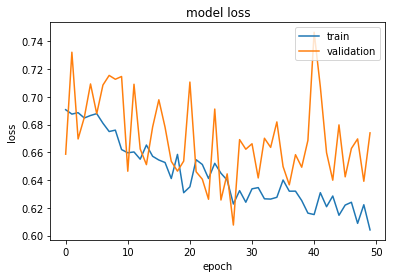

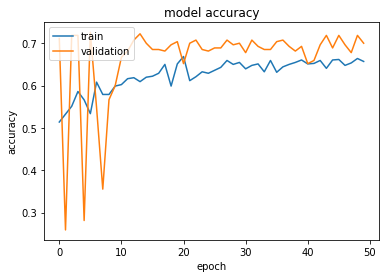

In [232]:
plot_model(history)

## Dense Binary Model

In [241]:
X_binary = X_binary.reshape(X_binary.shape[:2])
X_test = X_test.reshape(X_test.shape[:2])

In [174]:
# Binary Classifcation (Comment / No Comment)
model = Sequential()
model.add(Dense(100, input_shape=(WINDOW_SIZE,)))
model.add(Dense(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True) 

history = model.fit(X_binary, y_binary,
              validation_data=(X_test, 1 - y_test[:, 5]),
              epochs=50, batch_size=8)

Train on 852 samples, validate on 270 samples
Epoch 1/50
852/852 [==============================] - 1s 707us/step - loss: 0.6903 - acc: 0.5563 - val_loss: 0.7022 - val_acc: 0.6778
Epoch 2/50
852/852 [==============================] - 0s 214us/step - loss: 0.6823 - acc: 0.6232 - val_loss: 0.7117 - val_acc: 0.6704
Epoch 3/50
852/852 [==============================] - 0s 215us/step - loss: 0.6786 - acc: 0.6150 - val_loss: 0.7311 - val_acc: 0.5815
Epoch 4/50
852/852 [==============================] - 0s 212us/step - loss: 0.6788 - acc: 0.6291 - val_loss: 0.6884 - val_acc: 0.6815
Epoch 5/50
852/852 [==============================] - 0s 215us/step - loss: 0.6772 - acc: 0.6009 - val_loss: 0.6911 - val_acc: 0.6926
Epoch 6/50
852/852 [==============================] - 0s 215us/step - loss: 0.6774 - acc: 0.6268 - val_loss: 0.6984 - val_acc: 0.6889
Epoch 7/50
852/852 [==============================] - 0s 214us/step - loss: 0.6799 - acc: 0.6162 - val_loss: 0.7235 - val_acc: 0.6407
Epoch 8/50
852/8

In [175]:
predictions = model.predict_classes(X_test)

In [176]:
print('Weighted Accuracy', balanced_accuracy_score(1 - y_test[:, 5], predictions))
print('Geometric mean of recall and specificity:', geometric_mean_score(1 - y_test[:,5], predictions), '\n')
print(classification_report_imbalanced(1 - y_test[:,5], predictions))

Weighted Accuracy 0.5407754010695187
Geometric mean of recall and specificity: 0.46966821831386213 

                   pre       rec       spe        f1       geo       iba       sup

          0       0.77      0.81      0.27      0.79      0.47      0.23       204
          1       0.32      0.27      0.81      0.29      0.47      0.21        66

avg / total       0.66      0.68      0.40      0.67      0.47      0.23       270



In [177]:
print(recall_score(1-y_test[:, 5], predictions))
print(f1_score(1-y_test[:, 5], predictions))
print(accuracy_score(1-y_test[:, 5],predictions))

0.2727272727272727
0.2926829268292683
0.6777777777777778


## No Comment / Comment Metrics

In [717]:
predictions = model.predict_classes(X_test)
score = model.predict(X_test)

In [719]:
conf_matrix = confusion_matrix(1 - y_test[:,5], predictions)
conf_matrix

array([[188,  22],
       [ 42,  18]])

<table align='left'> 
    <tr> 
        <td>TN</td>
        <td>FP</td>
    </tr>
    <tr> 
        <td>FN</td>
        <td>TP</td>
    </tr>    
</table>

In [720]:
tn, fp, fn, tp = conf_matrix.ravel()
print(tn, fp, fn, tp, sep=', ')

188, 22, 42, 18


In [721]:
precision = tp / (tp + fp)
precision

0.45

In [722]:
recall = tp / (tp + fn)
recall

0.3

In [723]:
fscore = 2 * precision * recall / (precision + recall)
fscore

0.36000000000000004

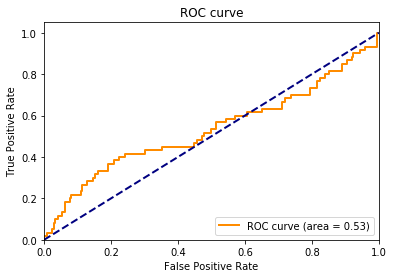

In [724]:
fpr, tpr, thr = roc_curve(1 - y_test[:, 5], score, pos_label=1)
roc_auc = auc(fpr, tpr)


plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

In [725]:
best_thr = thr[np.argmin((0 - fpr)**2 + (1 - tpr)**2)] # Closest threshold to (0, 1) on ROC curve

In [726]:
predictions = [1 if x > best_thr else 0 for x in score] # After seeing ROC curve best threshold is ~0.3

In [727]:
conf_matrix = confusion_matrix(1 - y_test[:,5], predictions, )
conf_matrix

array([[159,  51],
       [ 36,  24]])

In [728]:
tn, fp, fn, tp = conf_matrix.ravel()

In [729]:
precision = tp / (tp + fp)
precision

0.32

In [730]:
recall = tp / (tp + fn)
recall

0.4

In [731]:
fscore = 2 * precision * recall / (precision + recall)
fscore

0.35555555555555557

In [734]:
accuracy_score(1-y_test[:, 5],predictions)

0.762962962962963

|Model| Precision | Recall | F-score | 
| --- | --- | --- | --- |
|Random Forest|  |  | |
|LSTM |  |  |  |

## Multiclass Model Hyperparameter Search

In [357]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [96]:
# class_weights = class_weight.compute_class_weight('balanced', 
#                                                  np.unique(np.argmax(y_train, 1)), 
#                                                  np.argmax(y_train,1))
# class_weights

array([ 1.15533981,  1.88888889, 14.875     ,  1.7761194 ,  5.40909091,
        0.26385809])

In [375]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [359]:
def create_model(hidden_size=150, dropout=0.2, recurrent_dropout=0.2):
    model = Sequential()
    model.add(LSTM(hidden_size, input_shape=(WINDOW_SIZE, 1),
                  dropout=dropout, recurrent_dropout=recurrent_dropout))
    model.add(Dense(6, activation='softmax')) 
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam')
    return model

In [360]:
# Custom TransformerMixin to reshape data after oversampling

# from sklearn.base import TransformerMixin

# class Reshape(TransformerMixin):

#     def transform(self, X):
        
#         return X.reshape(*X.shape, 1)

#     def fit(self, X, y=None, **fit_params):
#         return self

# Saved in utils.py

In [78]:
from imblearn.metrics import geometric_mean_score
from imblearn.metrics import classification_report_imbalanced

In [355]:
from utils import Reshape

In [398]:
model = Pipeline([
    ('sampling', RandomOverSampler()),# Try with SMOTE 
    ('reshape', Reshape()),
    ('clf', KerasClassifier(create_model, verbose=0))
])

# Grid search parameters
hidden_size = [60, 80, 100, 150]
epochs = [30, 40, 50, 60, 70]
batch_size = [8, 16, 32]
dropout = [0.2, 0.5]
recurrent_dropout = [0.2, 0.5]

scorer = make_scorer(geometric_mean_score, average='micro')

param_grid = {'clf__hidden_size':hidden_size,
              'clf__batch_size':batch_size,
              'clf__epochs':epochs,
              'clf__dropout':dropout,
              'clf__recurrent_dropout':recurrent_dropout}

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scorer, cv=5, n_jobs=-1)
#'balanced_accuracy'
#                     scoring={'f1_micro':'f1_micro', 'f1_macro':'f1_micro'}, refit='f1_macro')

grid_search = grid.fit(X_train, np.argmax(y_train, axis=1))


# hyperas module for optimizing hyperparameters

/root/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/root/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [399]:
grid_search.best_params_, grid_search.best_score_

({'clf__batch_size': 16,
  'clf__dropout': 0.2,
  'clf__epochs': 70,
  'clf__hidden_size': 150,
  'clf__recurrent_dropout': 0.2},
 0.6403939840480054)

In [400]:
predictions = to_categorical(grid_search.predict(X_test))

In [401]:
sum(predictions)

array([ 32.,  13.,   4.,  49.,  18., 154.], dtype=float32)

In [405]:
scores = grid_search.cv_results_['mean_test_score']
# f1_micro = grid_search.cv_results_['mean_test_f1_micro']
# f1_macro = grid_search.cv_results_['mean_test_f1_macro']
params = grid_search.cv_results_['params']

for score, param in zip(scores, params):
    if score > 0.6:
        print(score, param)
# [x for x in zip(grid_search.cv_results_['mean_test_score'], grid_search.cv_results_['params'])]

0.6120495228035486 {'clf__batch_size': 8, 'clf__dropout': 0.2, 'clf__epochs': 30, 'clf__hidden_size': 150, 'clf__recurrent_dropout': 0.2}
0.6056122893295801 {'clf__batch_size': 8, 'clf__dropout': 0.2, 'clf__epochs': 40, 'clf__hidden_size': 100, 'clf__recurrent_dropout': 0.2}
0.6179301352638126 {'clf__batch_size': 8, 'clf__dropout': 0.2, 'clf__epochs': 40, 'clf__hidden_size': 150, 'clf__recurrent_dropout': 0.2}
0.6306636759236092 {'clf__batch_size': 8, 'clf__dropout': 0.2, 'clf__epochs': 50, 'clf__hidden_size': 150, 'clf__recurrent_dropout': 0.2}
0.6213344342762661 {'clf__batch_size': 8, 'clf__dropout': 0.2, 'clf__epochs': 60, 'clf__hidden_size': 80, 'clf__recurrent_dropout': 0.2}
0.614920169844267 {'clf__batch_size': 8, 'clf__dropout': 0.2, 'clf__epochs': 60, 'clf__hidden_size': 100, 'clf__recurrent_dropout': 0.2}
0.6028896799586745 {'clf__batch_size': 8, 'clf__dropout': 0.2, 'clf__epochs': 60, 'clf__hidden_size': 150, 'clf__recurrent_dropout': 0.2}
0.6117682581475774 {'clf__batch_size

In [410]:
sum(predictions)

array([ 32.,  13.,   4.,  49.,  18., 154.], dtype=float32)

In [411]:
sum(y_test)

array([ 22,  21,   3,  11,   5, 208])

In [412]:
geometric_mean_score(np.argmax(y_test, 1), np.argmax(predictions, 1), average='micro')

0.6763271259858703

## Multiclass Model

In [330]:
X_train = X_train.reshape(*X_train.shape, 1)
X_test = X_test.reshape(*X_test.shape, 1)

In [331]:
X_resampled = X_resampled.reshape(*X_resampled.shape, 1)

In [333]:
pre = []
rec = []
fs = []
gms = []
wa = []

for _ in range(10):
# Bidirectional LSTM

    model = Sequential()
    model.add(LSTM(150, input_shape=(WINDOW_SIZE, 1),
                   dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(6, activation='softmax')) 
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True) 
    # filepath = 'models/multiclass_model.h5'
    # checkpoint = ModelCheckpoint(filepath, monitor='val-loss', verbose=1, save_best_only=True)

    history = model.fit(X_resampled, y_resampled,
                  validation_data=(X_test, y_test),
                  epochs=50, batch_size=16, verbose=0)
    predictions = model.predict_classes(X_test)
    pre.append(precision_score(np.argmax(y_test, 1), predictions, average='weighted'))
    rec.append(recall_score(np.argmax(y_test, 1), predictions, average='weighted'))
    fs.append(f1_score(np.argmax(y_test, 1), predictions, average='weighted'))
    gms.append(geometric_mean_score(np.argmax(y_test, 1), predictions, average='weighted'))
    wa.append(balanced_accuracy_score(np.argmax(y_test, 1), predictions))
    

In [361]:
pre = []
rec = []
fs = []
gms = []

for _ in range(10):
    
    cv = KFold(n_splits=5, shuffle=True)
    
    model = Pipeline([
        ('sampling', RandomOverSampler()), 
        ('reshape', Reshape()),
        ('clf', KerasClassifier(create_model, epochs=60, batch_size=8, verbose=0))
    ])

    scoring = {'precision': make_scorer(precision_score, average='weighted'),
               'recall': make_scorer(recall_score, average='weighted'),
               'f1': make_scorer(f1_score, average='weighted'),
              'geom': make_scorer(geometric_mean_score , average='weighted')}

    scores = cross_validate(model, X, np.argmax(y, 1), cv=cv, scoring=scoring, n_jobs=-1)
    pre.append(np.mean(scores['test_precision']))
    rec.append(np.mean(scores['test_recall'])) 
    fs.append(np.mean(scores['test_f1']))    
    gms.append(np.mean(scores['test_geom']))


In [363]:
print(np.mean(pre), np.mean(rec), np.mean(fs), np.mean(gms))

0.5105276774857808 0.4607281587191089 0.48096592192151916 0.567618237739593


In [338]:
model = Sequential()
model.add(LSTM(150, input_shape=(WINDOW_SIZE, 1),
               dropout=0.5, recurrent_dropout=0.5))
model.add(Dense(6, activation='softmax')) 
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True) 
# filepath = 'models/multiclass_model.h5'
# checkpoint = ModelCheckpoint(filepath, monitor='val-loss', verbose=1, save_best_only=True)

history = model.fit(X_resampled, y_resampled,
              validation_data=(X_test, y_test),
              epochs=50, batch_size=16, verbose=1)

Train on 2580 samples, validate on 270 samples
Epoch 1/50
2580/2580 [==============================] - 8s 3ms/step - loss: 1.7902 - acc: 0.1783 - val_loss: 1.8245 - val_acc: 0.0296
Epoch 2/50
2580/2580 [==============================] - 3s 1ms/step - loss: 1.7777 - acc: 0.1934 - val_loss: 1.7958 - val_acc: 0.0370
Epoch 3/50
2580/2580 [==============================] - 3s 1ms/step - loss: 1.7668 - acc: 0.2043 - val_loss: 1.8010 - val_acc: 0.0926
Epoch 4/50
2580/2580 [==============================] - 3s 1ms/step - loss: 1.7596 - acc: 0.2054 - val_loss: 1.7604 - val_acc: 0.4889
Epoch 5/50
2580/2580 [==============================] - 3s 1ms/step - loss: 1.7527 - acc: 0.2178 - val_loss: 1.7914 - val_acc: 0.3593
Epoch 6/50
2580/2580 [==============================] - 3s 1ms/step - loss: 1.7479 - acc: 0.2194 - val_loss: 1.8301 - val_acc: 0.0926
Epoch 7/50
2580/2580 [==============================] - 3s 1ms/step - loss: 1.7287 - acc: 0.2291 - val_loss: 1.8040 - val_acc: 0.3444
Epoch 8/50
2580

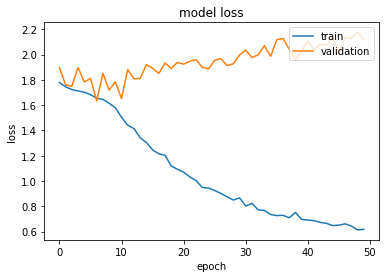

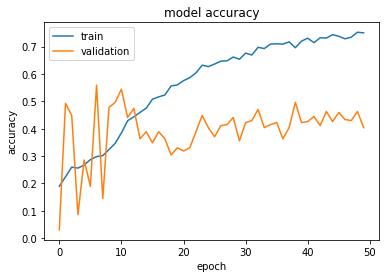

In [336]:
plot_model(history)

In [ ]:
# from keras.models import load_model
# model = load_model('models/binary_model.h5')

In [468]:
predictions = to_categorical(model.predict_classes(X_test))

In [469]:
predictions.sum(axis=0)

array([ 48.,  22.,   5.,  50.,  17., 128.], dtype=float32)

In [432]:
y_test.sum(axis=0)

array([ 22,  21,   3,  11,   5, 208])

In [472]:
tp = np.zeros(6)
fn = np.zeros(6)
fp = np.zeros(6)
tn = np.zeros(6)

for i in range(y_test.shape[1]):
    for j in range(y_test.shape[0]):
        if y_test[j, i] == 1:
            if predictions[j, i] == 1:
                tp[i] += 1
            else:
                fn[i] += 1
        else:
            if predictions[j, i] == 1:
                fp[i] += 1
            else:
                tn[i] += 1

In [473]:
print('TP\tFP')
print('FN\tTN')
print("\n")
for i in range(6):
    print(label_cols[i])
    print("%d\t%d" % (tp[i], fp[i]))
    print("%d\t%d" % (fn[i], tn[i]))    
    print("\n")

TP	FP
FN	TN


Promo
10	38
12	210


Phasing
3	19
18	230


SP&D
0	5
3	262


POS
2	48
9	211


Other
0	17
5	248


NoComm
112	16
96	46




In [474]:
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))
conf_matrix

array([[ 10,   2,   0,   5,   2,   3],
       [  4,   3,   0,   5,   2,   7],
       [  2,   0,   0,   1,   0,   0],
       [  3,   2,   0,   2,   0,   4],
       [  2,   0,   0,   1,   0,   2],
       [ 27,  15,   5,  36,  13, 112]])

In [475]:
precision = tp / (tp + fp)
precision = np.nan_to_num(precision)
precision

array([0.20833333, 0.13636364, 0.        , 0.04      , 0.        ,
       0.875     ])

In [476]:
recall = tp / (tp + fn)
recall

array([0.45454545, 0.14285714, 0.        , 0.18181818, 0.        ,
       0.53846154])

In [477]:
fscore = 2 * precision * recall / (precision + recall)
fscore = np.nan_to_num(fscore)
fscore

/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


array([0.28571429, 0.13953488, 0.        , 0.06557377, 0.        ,
       0.66666667])

In [478]:
macro_fscore = fscore.mean()
macro_fscore

0.192914934432281

In [479]:
from sklearn.metrics import f1_score

f1_score(y_test, predictions, average='macro')

0.192914934432281

In [480]:
micro_precision = sum(tp) / (sum(tp) + sum(fp))
micro_recall = sum(tp) / (sum(tp) + sum(fn))
micro_fscore = 2 * micro_precision * micro_recall / (micro_precision + micro_recall)
micro_fscore

0.4703703703703704

In [481]:
f1_score(y_test, predictions, average='micro')

0.4703703703703704

In [482]:
print(classification_report_imbalanced(np.argmax(y_test, 1), np.argmax(predictions, 1)))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.21      0.45      0.85      0.29      0.62      0.37        22
          1       0.14      0.14      0.92      0.14      0.36      0.12        21
          2       0.00      0.00      0.98      0.00      0.00      0.00         3
          3       0.04      0.18      0.81      0.07      0.38      0.14        11
          4       0.00      0.00      0.94      0.00      0.00      0.00         5
          5       0.88      0.54      0.74      0.67      0.63      0.39       208

avg / total       0.70      0.47      0.77      0.55      0.58      0.35       270



## Multiclass Baseline (RandomForest)

In [387]:
X_resampled = X_resampled.reshape(*X_resampled.shape[:2])
X_train = X_train.reshape(*X_train.shape[:2])
X_test = X_test.reshape(*X_test.shape[:2])

In [388]:
X_resampled.shape

(2580, 13)

In [ ]:
df_c.head()

In [286]:
def plot_feature_importances(model, ax):
    n_features = WINDOW_SIZE
    ax.barh(range(n_features), model.feature_importances_, align='center')
#     ax.yticks(np.arange(n_features))
#     ax.setxlabel("Feature importance")
#     ax.ylabel("Feature")
#     ax.ylim(-1, n_features)

<BarContainer object of 13 artists>

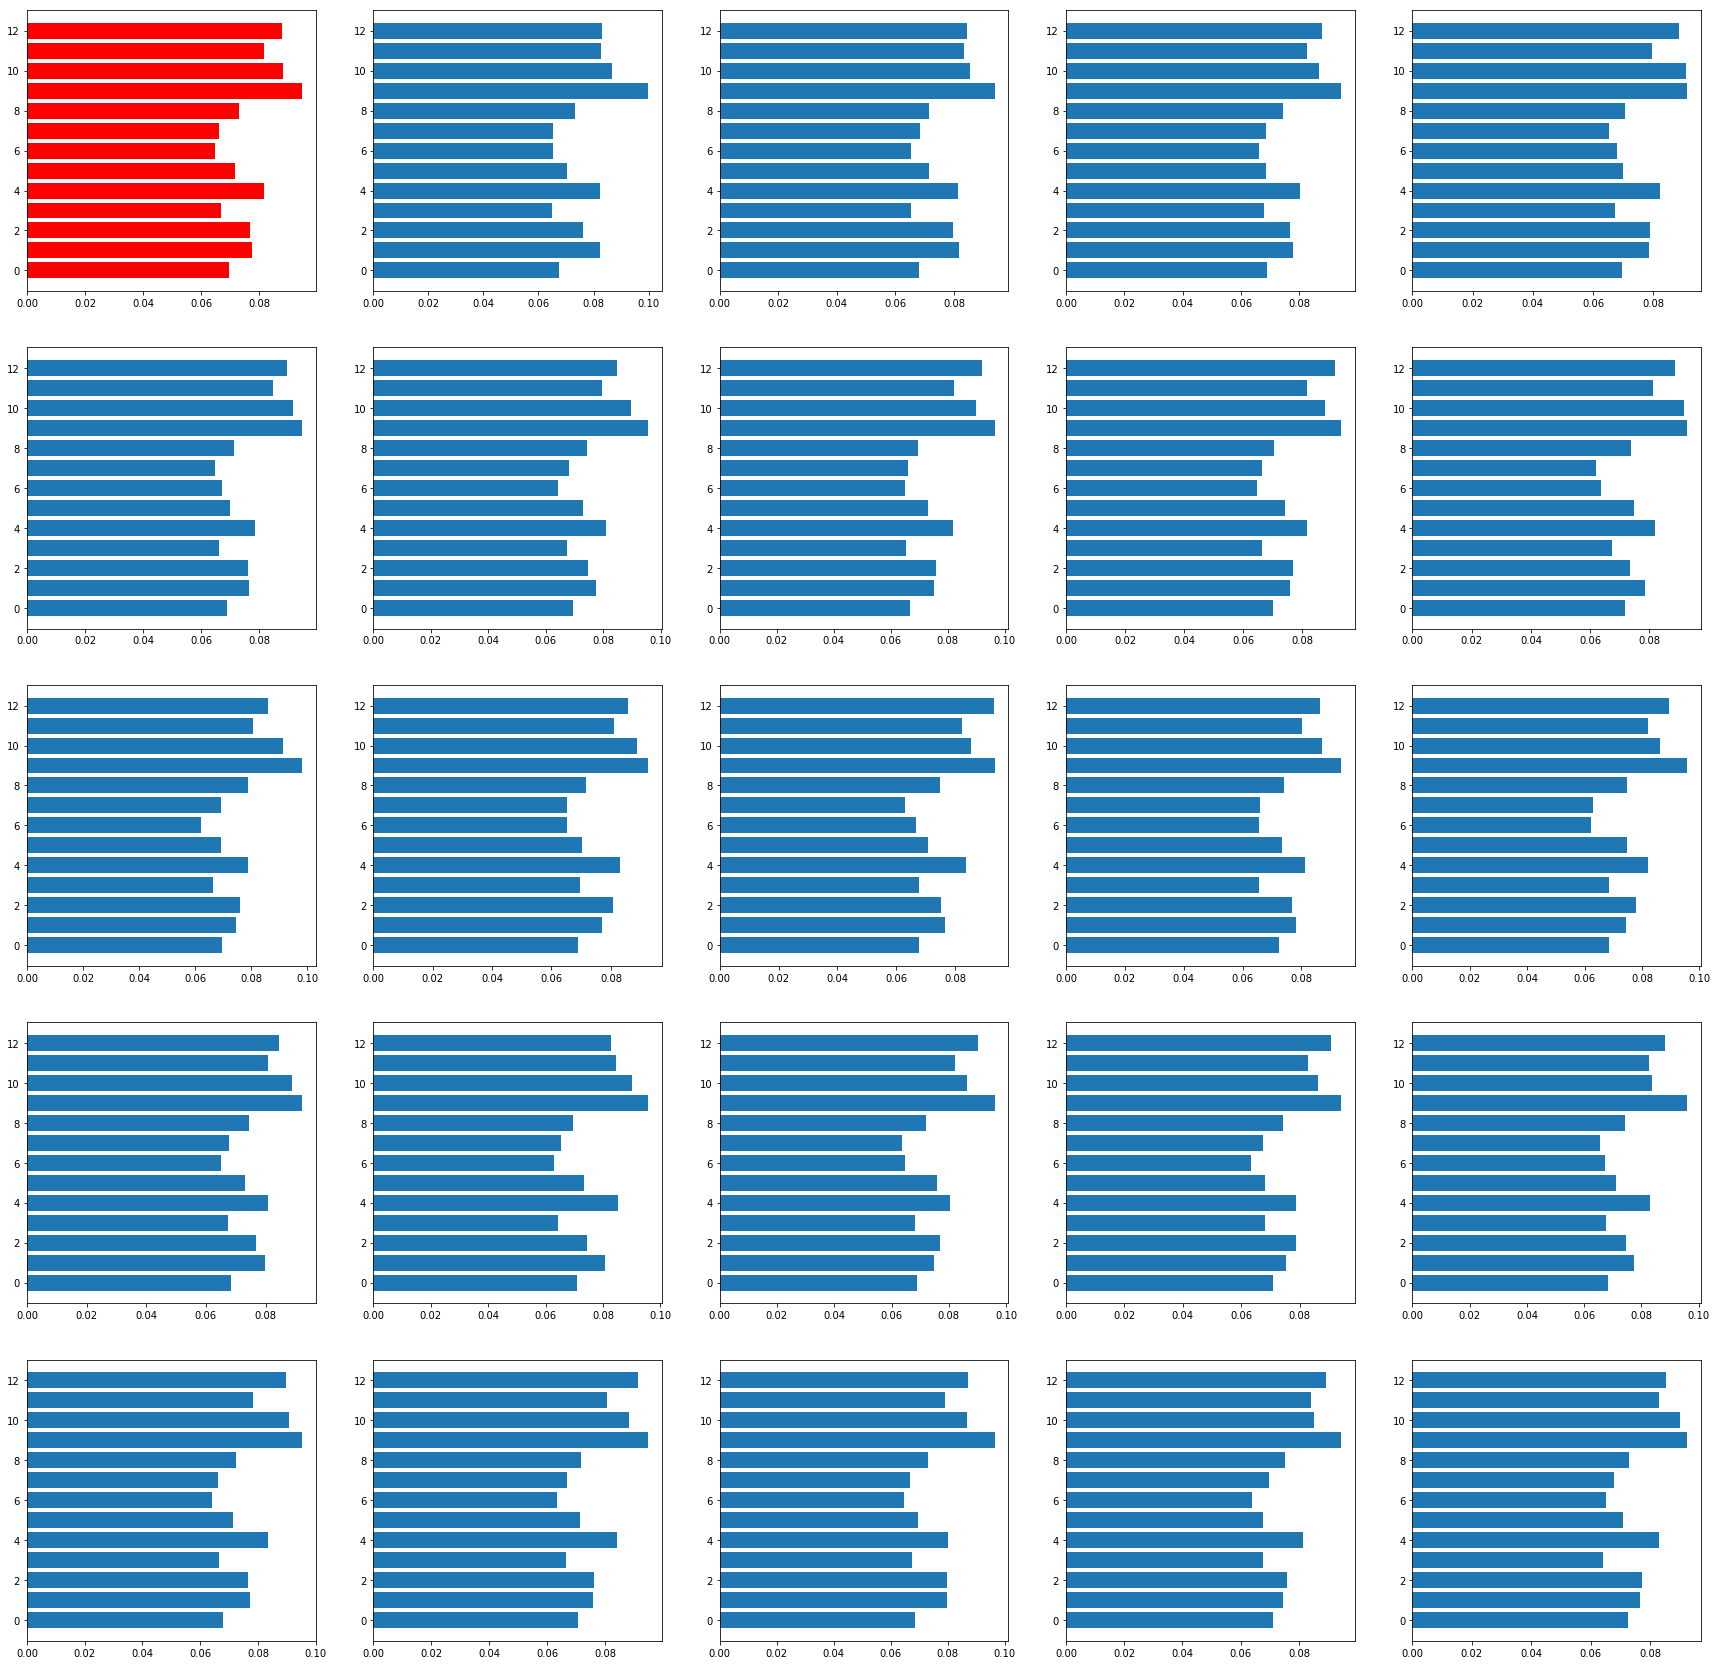

In [287]:
fig, axs = plt.subplots(5,5, figsize=(30,30))

axs = axs.ravel()

average_feature_importance = np.zeros(WINDOW_SIZE)
for i in range(1, 25):
    rf = RandomForestClassifier(200)
    rf.fit(X_resampled, np.argmax(y_resampled, 1))
    average_feature_importance += rf.feature_importances_
    plot_feature_importances(rf, axs[i])
average_feature_importance /= 24
axs[0].barh(range(WINDOW_SIZE), average_feature_importance, align='center', color='r')

In [328]:
pre = []
rec = []
fs = []
gms = []
wa = []
for _ in range(100):
    rf = RandomForestClassifier(200)
    rf.fit(X_resampled, np.argmax(y_resampled, 1))
    predictions = rf.predict(X_test)

    pre.append(precision_score(np.argmax(y_test, 1), predictions, average='weighted'))
    rec.append(recall_score(np.argmax(y_test, 1), predictions, average='weighted'))
    fs.append(f1_score(np.argmax(y_test, 1), predictions, average='weighted'))
    gms.append(geometric_mean_score(np.argmax(y_test, 1), predictions, average='weighted'))
    wa.append(balanced_accuracy_score(np.argmax(y_test, 1), predictions))

/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/

/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/

/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/

/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/

/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/

/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/

In [378]:
from sklearn import metrics
metrics.precision_recall_fscore_support(np.argmax(y_test, 1), rf_predictions)[3]

array([ 27,  18,   2,  18,   5, 200])

In [380]:
precision_score(np.argmax(y_test, 1), rf_predictions, average='weighted')

/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.654516711833785

In [ ]:
def custom_weighted_scorer(y_true, y_pred, scorer):
    _, _, _, supports = metrics.precision_recall_fscore_support(y_true, y_pred)
    
    if scorer == 'precision':
        scores = precision_score(y_true, y_pred)
    precision_tuple = precision_tuple[1:]
    support_tuple = support_tuple[:-1]
    weighted_precision = np.average(scores, weights=supports)
    return weighted_score

In [ ]:
pre = []
rec = []
fs = []
gms = []

for _ in range(1):
    
    cv = KFold(n_splits=5, shuffle=True)
    
    model = Pipeline([
        ('sampling', RandomOverSampler()), 
        ('clf', RandomForestClassifier(n_estimators=200))
    ])

    scoring = {'precision': make_scorer(precision_score, y_true=y_true[:-1],y_pred=y_pred[:-1], average='weighted')}
#                ,
#                'recall': make_scorer(recall_score, average='weighted'),
#                'f1': make_scorer(f1_score, average='weighted'),
#               'geom': make_scorer(geometric_mean_score , average='weighted')}

    scores = cross_validate(model, X, np.argmax(y, 1), cv=cv, scoring=scoring, n_jobs=-1)
    pre.append(np.mean(scores['test_precision']))
    rec.append(np.mean(scores['test_recall'])) 
    fs.append(np.mean(scores['test_f1']))    
    gms.append(np.mean(scores['test_geom']))


In [351]:
print(np.mean(pre), np.mean(rec), np.mean(fs), np.mean(gms))

0.47327395696184205 0.5982255482074488 0.5101027745819445 0.5381242785185694


In [321]:
print(classification_report_imbalanced(np.argmax(y_test, 1), rf_predictions))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.10      0.07      0.92      0.08      0.26      0.06        27
          1       0.50      0.11      0.99      0.18      0.33      0.10        18
          2       0.00      0.00      1.00      0.00      0.00      0.00         2
          3       0.11      0.06      0.97      0.07      0.23      0.05        18
          4       0.00      0.00      1.00      0.00      0.00      0.00         5
          5       0.76      0.90      0.19      0.82      0.41      0.18       200

avg / total       0.61      0.68      0.39      0.63      0.37      0.15       270



/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [487]:
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(rf_predictions, axis=1))
conf_matrix

array([[ 11,   0,   0,   0,   0,  11],
       [ 16,   0,   0,   0,   0,   5],
       [  3,   0,   0,   0,   0,   0],
       [  8,   0,   0,   0,   0,   3],
       [  4,   0,   0,   0,   0,   1],
       [ 77,   1,   0,   0,   0, 130]])

In [488]:
tp = np.zeros(6)
fn = np.zeros(6)
fp = np.zeros(6)
tn = np.zeros(6)

for i in range(y_test.shape[1]):
    for j in range(y_test.shape[0]):
        if y_test[j, i] == 1:
            if rf_predictions[j, i] == 1:
                tp[i] += 1
            else:
                fn[i] += 1
        else:
            if rf_predictions[j, i] == 1:
                fp[i] += 1
            else:
                tn[i] += 1

In [489]:
print('TP\tFP')
print('FN\tTN')
print("\n")
for i in range(6):
    print(label_cols[i])
    print("%d\t%d" % (tp[i], fp[i]))
    print("%d\t%d" % (fn[i], tn[i]))    
    print("\n")

TP	FP
FN	TN


Promo
0	1
22	247


Phasing
0	1
21	248


SP&D
0	0
3	267


POS
0	0
11	259


Other
0	0
5	265


NoComm
130	20
78	42




## Multilabel Model

In [105]:
# All classes (multilabel)
# Maybe leave out NoComment label?
model = Sequential()
model.add(LSTM(200, input_shape=(1, 12)))
model.add(Dense(4, activation='sigmoid')) 
model.compile(loss='binary_crossentropy', optimizer='adam')

model.fit(trainX, BR_TR_labels[:, :4], validation_split=0.1, epochs=6, batch_size=8)

Train on 603 samples, validate on 67 samples
Epoch 1/6
603/603 [==============================] - 1s 2ms/step - loss: 0.6381 - val_loss: 0.5557
Epoch 2/6
603/603 [==============================] - 0s 605us/step - loss: 0.4468 - val_loss: 0.3909
Epoch 3/6
603/603 [==============================] - 0s 584us/step - loss: 0.3635 - val_loss: 0.3699
Epoch 4/6
603/603 [==============================] - 0s 593us/step - loss: 0.3512 - val_loss: 0.3649
Epoch 5/6
603/603 [==============================] - 0s 594us/step - loss: 0.3466 - val_loss: 0.3632
Epoch 6/6
603/603 [==============================] - 0s 600us/step - loss: 0.3448 - val_loss: 0.3623


In [151]:
from sklearn.metrics import multilabel_confusion_matrix

ImportError: cannot import name 'multilabel_confusion_matrix'

In [108]:
predictions = model.predict(trainX)

In [144]:
c = predictions > 0.5 
np.where(c)[0]

array([169, 281])

In [111]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(4):
    precision[i], recall[i], _ = precision_recall_curve(BR_TR_labels[:, i],
                                                        predictions[:, i])
    average_precision[i] = average_precision_score(BR_TR_labels[:, i], predictions[:, i])

    
precision["micro"], recall["micro"], _ = precision_recall_curve(BR_TR_labels[:].ravel(),
    predictions[:].ravel())
average_precision["micro"] = average_precision_score(BR_TR_labels[:], predictions[:],
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))    

ValueError: Found input variables with inconsistent numbers of samples: [3350, 2680]

In [ ]:
df_c[df_c["WM"] == 1]

In [326]:
pre = []
rec = []
fs = []
gms = []
wa = []

for _ in range(1000):
    predictions = np.random.randint(6, size=len(y_test))

    pre.append(precision_score(np.argmax(y_test, 1), predictions, average='weighted'))
    rec.append(recall_score(np.argmax(y_test, 1), predictions, average='weighted'))
    fs.append(f1_score(np.argmax(y_test, 1), predictions, average='weighted'))
    gms.append(geometric_mean_score(np.argmax(y_test, 1), predictions, average='weighted'))
    wa.append(balanced_accuracy_score(np.argmax(y_test, 1), predictions))
    
# predictions = np.zeros(len(y_test)) + 5
# print(classification_report_imbalanced(np.argmax(y_test, 1), predictions))

In [327]:
print(np.mean(pre), np.mean(rec), np.mean(fs), np.mean(gms), np.mean(wa))

0.56858053811405 0.16504814814814814 0.2250185713086899 0.3703459368291807 0.1634129938271605


In [165]:
predictions = np.random.randint(2, size=len(y_test))
print('Weighted Accuracy', balanced_accuracy_score(1 - y_test[:, 5], predictions))
print('Geometric mean of recall and specificity:', geometric_mean_score(1 - y_test[:,5], predictions), '\n')
print(classification_report_imbalanced(1 - y_test[:,5], predictions))

Weighted Accuracy 0.46301247771836007
Geometric mean of recall and specificity: 0.46249729006288026 

                   pre       rec       spe        f1       geo       iba       sup

          0       0.73      0.44      0.48      0.55      0.46      0.21       204
          1       0.22      0.48      0.44      0.30      0.46      0.21        66

avg / total       0.60      0.45      0.47      0.49      0.46      0.21       270



In [205]:
pre = []
rec = []
fs = []
gms = []
wa = []
for _ in range(100000):
    predictions = np.random.randint(2, size=len(y_test))
    pre.append(precision_score(1 - y_test[:, 5], predictions))
    rec.append(recall_score(1 - y_test[:, 5], predictions))
    fs.append(f1_score(1 - y_test[:, 5], predictions))
    gms.append(geometric_mean_score(1 - y_test[:, 5], predictions))
    wa.append(balanced_accuracy_score(1 - y_test[:, 5], predictions))

In [237]:
np.mean(rec)

0.24445403902821658

In [352]:
pre = []
rec = []
fs = []
gms = []


for tr, te in KFold(n_splits=5, shuffle=True).split(X, y):
    for _ in range(1000):
        predictions = np.random.randint(6, size=len(y[te]))

        pre.append(precision_score(np.argmax(y[te], 1), predictions, average='weighted'))
        rec.append(recall_score(np.argmax(y[te], 1), predictions, average='weighted'))
        fs.append(f1_score(np.argmax(y[te], 1), predictions, average='weighted'))
        gms.append(geometric_mean_score(np.argmax(y[te], 1), predictions, average='weighted'))

/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [353]:
print(np.mean(pre), np.mean(rec), np.mean(fs), np.mean(gms))

0.43448491891782187 0.16671679081099897 0.21139656998666395 0.3713909516678196
